<a href="https://colab.research.google.com/github/quanmtran/Coursera_Capstone/blob/main/Coursera_Capstone_Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Capstone Project Notebook**

In [1]:
import pandas as pd
import numpy as np

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# **Week 3: Segmenting and Clustering neighborhoods in Toronto**

In [3]:
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## **1. Scraping dataset of Toronto's neighborhoods**

In [4]:
# Scrape the table from the web page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, 'lxml')
table = soup.find_all('table')

# Store the table in df_table
df_table = pd.read_html(str(table))[0]
df_table.columns = ['PostalCode', 'Borough', 'Neighborhood'] # Select columns
df_table = df_table[df_table['Borough'] != 'Not assigned'] # Keep assigned boroughs only
df_table.reset_index(drop=True, inplace=True)

In [5]:
df_table.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df_table.shape

(103, 3)

## **2. Adding geographical coordinates**

### 2.1. Getting coordinates data

In [7]:
# Read the Geospatial_Coordinates.csv and store in df_geo.
url = 'https://raw.githubusercontent.com/quanmtran/Coursera_Capstone/main/Geospatial_Coordinates.csv'

df_geo = pd.read_csv(url)
df_geo.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

In [8]:
df_geo.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
df_geo.shape

(103, 3)

### 2.2. Adding coordinates

In [10]:
# Merge df_table and df_geo based on Postal code
df_toronto = df_table.merge(df_geo, how='left', on='PostalCode')

# Merge Borough and PostalCode into one attribute, i.e., Borough_Pcode
df_toronto['Borough_Pcode'] = df_toronto[['PostalCode', 'Borough']].apply(lambda x: ', '.join(x), axis=1)

# Sort by Borough_Pcode
df_toronto.sort_values(by=['Borough_Pcode'], inplace=True, ignore_index=True)

# Select attributes
df_toronto = df_toronto[['Borough_Pcode', 'Neighborhood', 'Latitude', 'Longitude']]

In [11]:
df_toronto.head()

,Borough_Pcode,Neighborhood,Latitude,Longitude
0,"M1B, Scarborough","Malvern, Rouge",43.806686,-79.194353
1,"M1C, Scarborough","Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,"M1E, Scarborough","Guildwood, Morningside, West Hill",43.763573,-79.188711
3,"M1G, Scarborough",Woburn,43.770992,-79.216917
4,"M1H, Scarborough",Cedarbrae,43.773136,-79.239476


In [12]:
df_toronto.shape

(103, 4)

### 2.3. Displaying Toronto's map

In [13]:
# Get Toronto's coordinates
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode('Toronto, Canada')
toronto_lat = location.latitude
toronto_lon = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_lat, toronto_lon))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:
# Create Toronto's map
map_toronto = folium.Map(location=[toronto_lat, toronto_lon], zoom_start=10)

# Add markers to map
for borough, lat, lon in zip(df_toronto['Borough_Pcode'], df_toronto['Latitude'], df_toronto['Longitude']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## **3. Clustering boroughs in Toronto**

### 3.1. Getting nearby venues

In [15]:
CLIENT_ID = 'A2ZJ4CROF23YOL3Q3POSEQUOPVSMPG50CYLYORJGV2NNVC5D' # your Foursquare ID
CLIENT_SECRET = 'KU30MIJOC3GF5E2SK1V0XJU3CSYHS2YIHWVOHW1VTAVMM4DL' # your Foursquare Secret
VERSION = '20201029' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [16]:
# Function that gets nearby venues within radius of 1.5km
def getNearbyVenues(boroughs, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for borough, lat, lon in zip(boroughs, latitudes, longitudes):
      
      # Create the API request URL
      url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID,
          CLIENT_SECRET,
          VERSION,
          lat,
          lon,
          radius,
          LIMIT)
      
      # Make the GET request
      results = requests.get(url).json()['response']['groups'][0]['items']
      
      # Return only relevant information for each nearby venue
      venues_list.append([(
          borough,
          lat,
          lon,
          v['venue']['name'],
          v['venue']['location']['lat'],
          v['venue']['location']['lng'],
          v['venue']['categories'][0]['name']) for v in results])

    df_nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    df_nearby_venues.columns = ['Borough_Pcode',
                                'Borough Latitude',
                                'Borough Longitude',
                                'Venue',
                                'Venue Latitude',
                                'Venue Longitude',
                                'Venue Category']

    return(df_nearby_venues)

In [17]:
# Get nearby venues of each borough in Toronto
df_toronto_venues = getNearbyVenues(boroughs = df_toronto['Borough_Pcode'],
                                    latitudes = df_toronto['Latitude'],
                                    longitudes = df_toronto['Longitude'])

df_toronto_venues.head()

,Borough_Pcode,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"M1B, Scarborough",43.806686,-79.194353,Images Salon & Spa,43.802283,-79.198565,Spa
1,"M1B, Scarborough",43.806686,-79.194353,Harvey's,43.800020,-79.198307,Restaurant
2,"M1B, Scarborough",43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
3,"M1B, Scarborough",43.806686,-79.194353,Canadiana exhibit,43.817962,-79.193374,Zoo Exhibit
4,"M1B, Scarborough",43.806686,-79.194353,Staples Morningside,43.800285,-79.196607,Paper / Office Supplies Store


In [18]:
df_toronto_venues.shape

(6865, 7)

In [19]:
# Count the number of venues around each borough
df_toronto_venues['Borough_Pcode'].value_counts().to_frame().sort_index().rename(columns={'Borough_Pcode': 'Venue count'})

,Venue count
"M1B, Scarborough",35
"M1C, Scarborough",11
"M1E, Scarborough",33
"M1G, Scarborough",32
"M1H, Scarborough",62
...,...
"M9N, York",51
"M9P, Etobicoke",31
"M9R, Etobicoke",41
"M9V, Etobicoke",35


In [20]:
print('There are {} uniques categories.'.format(len(df_toronto_venues['Venue Category'].unique())))

There are 346 uniques categories.


### 3.2. Getting frequency of venues

One-hot encoding venues

In [21]:
# One-hot encoding venues
df_toronto_venues_onehot = pd.get_dummies(df_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
df_toronto_venues_onehot['Borough_Pcode'] = df_toronto_venues['Borough_Pcode'] 

# Move Borough_Pcode column to the first column
fixed_columns = [df_toronto_venues_onehot.columns[-1]] + list(df_toronto_venues_onehot.columns[:-1])
df_toronto_venues_onehot = df_toronto_venues_onehot[fixed_columns]

df_toronto_venues_onehot.head()

,Borough_Pcode,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,...,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"M1B, Scarborough",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"M1B, Scarborough",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"M1B, Scarborough",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"M1B, Scarborough",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,"M1B, Scarborough",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Calculating frequency of venues for each borough

In [22]:
df_toronto_venues_freq = df_toronto_venues_onehot.groupby('Borough_Pcode').mean().reset_index()
df_toronto_venues_freq

,Borough_Pcode,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,...,Supplement Shop,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,"M1B, Scarborough",0.0,0.0,0.028571,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.028571,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028571,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.028571,0.000000,0.0,0.0,0.0,0.0,0.028571,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.028571,0.0,0.000000,0.0,0.285714
1,"M1C, Scarborough",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,"M1E, Scarborough",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.000000,0.0000,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.000000,0.060606,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.060606,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,"M1G, Scarborough",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.031250,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.031250,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.031250,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,"M1H, Scarborough",0.0,0.0,0.000000,0.0,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.016129,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.032258,0.032258,0.016129,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.016129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,0.000000,0.0,0.016129,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016129,0.0,0.000000,0.0,0.0,0.0,0.0,0.016129,0.016129,0.0,0.016129,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"M9N, York",0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,0.000000,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.058824,0.019608,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.019608,0.0

### 3.3. Getting top 10 venues by frequency

In [23]:
# # Top 10 venues by frequency in each borough
# for borough in df_toronto_venues_freq['Borough_Pcode']:
#     print("----"+borough+"----")
#     temp = df_toronto_venues_freq[df_toronto_venues_freq['Borough_Pcode'] == borough].T.reset_index()
#     temp.columns = ['Venue','Frequency']
#     temp = temp.iloc[1:]
#     temp['Frequency'] = temp['Frequency'].astype(float)
#     temp = temp.round({'Frequency': 2})
#     print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(10))
#     print('\n')

In [24]:
# Function that returns top n venues in each borough
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Borough_Pcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
df_toronto_venues_topn = pd.DataFrame(columns=columns)
df_toronto_venues_topn['Borough_Pcode'] = df_toronto_venues_freq['Borough_Pcode']

for i in np.arange(df_toronto_venues_freq.shape[0]):
    df_toronto_venues_topn.iloc[i, 1:] = return_most_common_venues(df_toronto_venues_freq.iloc[i, :], num_top_venues)

df_toronto_venues_topn

,Borough_Pcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"M1B, Scarborough",Zoo Exhibit,Fast Food Restaurant,Pizza Place,Restaurant,Paper / Office Supplies Store,Supermarket,Big Box Store,Gas Station,Trail,Chinese Restaurant
1,"M1C, Scarborough",Park,Breakfast Spot,Italian Restaurant,Grocery Store,Gym / Fitness Center,Playground,Neighborhood,Pizza Place,Burger Joint,Gym
2,"M1E, Scarborough",Pizza Place,Bank,Train Station,Breakfast Spot,Fast Food Restaurant,Coffee Shop,Liquor Store,Food & Drink Shop,Grocery Store,Greek Restaurant
3,"M1G, Scarborough",Coffee Shop,Pizza Place,Pharmacy,Supermarket,Fast Food Restaurant,Sandwich Place,Juice Bar,Bank,Gym,Chinese Restaurant
4,"M1H, Scarborough",Coffee Shop,Sandwich Place,Clothing Store,Restaurant,Gas Station,Indian Restaurant,Pharmacy,Sporting Goods Shop,Bakery,Light Rail Station
...,...,...,...,...,...,...,...,...,...,...,...
98,"M9N, York",Bakery,Grocery Store,Sandwich Place,Pizza Place,Gas Station,Train Station,Vietnamese Restaurant,Coffee Shop,Furniture / Home Store,Fast Food Restaurant
99,"M9P, Etobicoke",Pizza Place,Coffee Shop,Bank,Grocery Store,Chinese Restaurant,Sandwich Place,Supermarket,Café,Park,Skating Rink
100,"M9R, Etobicoke",Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Sporting Goods Shop,Shopping Mall,Beer Store,Liquor Store,Bank,American Restaurant
101,"M9V, Etobicoke",Fast Food Restaurant,Coffee Shop,Grocery Store,Pizza Place,Sandwich Place,Caribbean Restaurant,Pharmacy,Burger Joint,Greek Restaurant,Liquor Store


### 3.4. K-means clustering

#### 3.4.1. Finding best value of k

In [26]:
# Use venue frequency for clustering
df_toronto_clustering = df_toronto_venues_freq.drop('Borough_Pcode', 1)

# Calculate Sum of squared distance for k ranging from 1 to 20
k_range = range(1,21)
sse = []
for k in k_range:
  kmeans = KMeans(n_clusters=k, n_init=20, random_state=1996).fit(df_toronto_clustering)
  sse.append(kmeans.inertia_)

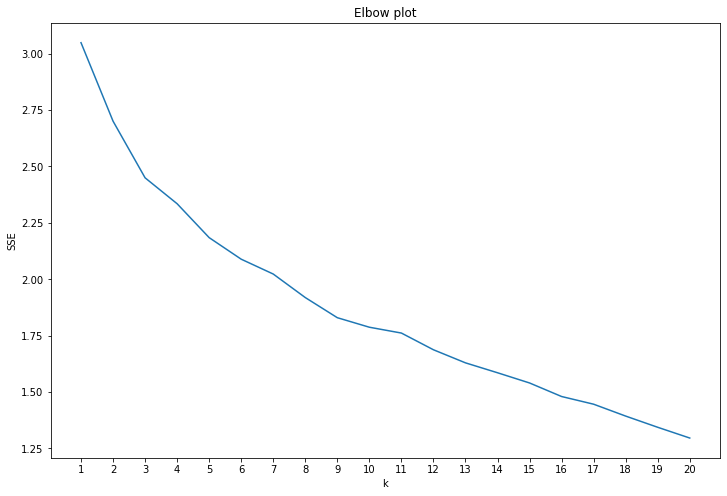

In [27]:
# Elbow plot
plt.figure(figsize=(12,8))
plt.title('Elbow plot')
plt.ylabel('SSE')
plt.xlabel('k')
plt.xticks(k_range)
plt.plot(k_range, sse)

We will choose k = 3 according to the Elbow plot.

#### 3.4.2. Clustering with the best k

In [28]:
k=3
kmeans = KMeans(n_clusters=k, n_init=20, random_state=1996).fit(df_toronto_clustering)

# Cluster labels
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### 3.5. Result

#### 3.5.1. Combining all information

In [29]:
# Add cluster labels
df_toronto_venues_topn.insert(1, 'Cluster', kmeans.labels_)

# Add latitude/longitude
df_toronto_final = df_toronto.merge(df_toronto_venues_topn, how='left', on='Borough_Pcode')

df_toronto_final

,Borough_Pcode,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"M1B, Scarborough","Malvern, Rouge",43.806686,-79.194353,1,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Restaurant,Paper / Office Supplies Store,Supermarket,Big Box Store,Gas Station,Trail,Chinese Restaurant
1,"M1C, Scarborough","Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Park,Breakfast Spot,Italian Restaurant,Grocery Store,Gym / Fitness Center,Playground,Neighborhood,Pizza Place,Burger Joint,Gym
2,"M1E, Scarborough","Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Pizza Place,Bank,Train Station,Breakfast Spot,Fast Food Restaurant,Coffee Shop,Liquor Store,Food & Drink Shop,Grocery Store,Greek Restaurant
3,"M1G, Scarborough",Woburn,43.770992,-79.216917,1,Coffee Shop,Pizza Place,Pharmacy,Supermarket,Fast Food Restaurant,Sandwich Place,Juice Bar,Bank,Gym,Chinese Restaurant
4,"M1H, Scarborough",Cedarbrae,43.773136,-79.239476,1,Coffee Shop,Sandwich Place,Clothing Store,Restaurant,Gas Station,Indian Restaurant,Pharmacy,Sporting Goods Shop,Bakery,Light Rail Station
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,"M9N, York",Weston,43.706876,-79.518188,1,Bakery,Grocery Store,Sandwich Place,Pizza Place,Gas Station,Train Station,Vietnamese Restaurant,Coffee Shop,Furniture / Home Store,Fast Food Restaurant
99,"M9P, Etobicoke",Westmount,43.696319,-79.532242,1,Pizza Place,Coffee Shop,Bank,Grocery Store,Chinese Restaurant,Sandwich Place,Supermarket,Café,Park,Skating Rink
100,"M9R, Etobicoke","Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,1,Pizza Place,Coffee Shop,Pharmacy,Sandwich Place,Sporting Goods Shop,Shopping Mall,Beer Store,Liquor Store,Bank,American Restaurant
101,"M9V, Etobicoke","South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,1,Fast Food Restaurant,Coffee Shop,Grocery Store,Pizza Place,Sandwich Place,Caribbean Restaurant,Pharmacy,Burger Joint,Greek Restaurant,Liquor Store


#### 3.5.2. Displaying clusters on map

In [30]:
# create map
map_clusters = folium.Map(location=[toronto_lat, toronto_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, borough, cluster in zip(df_toronto_final['Latitude'],
                                      df_toronto_final['Longitude'],
                                      df_toronto_final['Borough_Pcode'],
                                      df_toronto_final['Cluster']):
    label = folium.Popup(str(borough) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### 3.5.3. Clusters

**Cluster 0**

In [31]:
df_toronto_final.loc[df_toronto_final['Cluster'] == 0, :]

,Borough_Pcode,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"M1N, Scarborough","Birch Cliff, Cliffside West",43.692657,-79.264848,0,Park,Diner,Restaurant,Café,Golf Course,General Entertainment,Gym,Filipino Restaurant,Thai Restaurant,Ice Cream Shop
40,"M4J, East York","East Toronto, Broadview North (Old East York)",43.685347,-79.338106,0,Greek Restaurant,Coffee Shop,Café,Pizza Place,Park,Ethiopian Restaurant,Ice Cream Shop,Bakery,Pub,Italian Restaurant
41,"M4K, East Toronto","The Danforth West, Riverdale",43.679557,-79.352188,0,Café,Greek Restaurant,Park,Coffee Shop,Pizza Place,Bakery,Pub,Italian Restaurant,Ice Cream Shop,Vietnamese Restaurant
42,"M4L, East Toronto","India Bazaar, The Beaches West",43.668999,-79.315572,0,Indian Restaurant,Coffee Shop,Park,Bakery,Brewery,Grocery Store,Café,BBQ Joint,Beach,Pub
43,"M4M, East Toronto",Studio District,43.659526,-79.340923,0,Coffee Shop,Bar,Vietnamese Restaurant,Brewery,Park,Diner,Café,Bakery,French Restaurant,Restaurant
44,"M4N, Central Toronto",Lawrence Park,43.728020,-79.388790,0,Coffee Shop,Sushi Restaurant,Italian Restaurant,Bakery,Sandwich Place,Asian Restaurant,Park,Bank,Pub,Dog Run
45,"M4P, Central Toronto",Davisville North,43.712751,-79.390197,0,Coffee Shop,Italian Restaurant,Park,Gym,Deli / Bodega,Pizza Place,Restaurant,Café,Bakery,Indian Restaurant
46,"M4R, Central Toronto","North Toronto West, Lawrence Park",43.715383,-79.405678,0,Coffee Shop,Italian Restaurant,Fast Food Restaurant,Café,Restaurant,Bakery,Sushi Restaurant,Japanese Restaurant,Park,Pizza Place
47,"M4S, Central Toronto",Davisville,43.704324,-79.388790,0,Coffee Shop,Italian Restaurant,Pizza Place,Bakery,Indian Restaurant,Gym,Café,Park,Restaurant,Japanese Restaurant
48,"M4T, Central Toronto","Moore Park, Summerhill East",43.689574,-79.383160,0,Park,Italian Restaurant,Coffee Shop,Sushi Restaurant,Grocery Store,Café,Liquor Store,Bakery,Thai Restaurant,Kids Store


**Cluster 1**

In [32]:
df_toronto_final.loc[df_toronto_final['Cluster'] == 1, :]

,Borough_Pcode,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"M1B, Scarborough","Malvern, Rouge",43.806686,-79.194353,1,Zoo Exhibit,Fast Food Restaurant,Pizza Place,Restaurant,Paper / Office Supplies Store,Supermarket,Big Box Store,Gas Station,Trail,Chinese Restaurant
1,"M1C, Scarborough","Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Park,Breakfast Spot,Italian Restaurant,Grocery Store,Gym / Fitness Center,Playground,Neighborhood,Pizza Place,Burger Joint,Gym
2,"M1E, Scarborough","Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Pizza Place,Bank,Train Station,Breakfast Spot,Fast Food Restaurant,Coffee Shop,Liquor Store,Food & Drink Shop,Grocery Store,Greek Restaurant
3,"M1G, Scarborough",Woburn,43.770992,-79.216917,1,Coffee Shop,Pizza Place,Pharmacy,Supermarket,Fast Food Restaurant,Sandwich Place,Juice Bar,Bank,Gym,Chinese Restaurant
4,"M1H, Scarborough",Cedarbrae,43.773136,-79.239476,1,Coffee Shop,Sandwich Place,Clothing Store,Restaurant,Gas Station,Indian Restaurant,Pharmacy,Sporting Goods Shop,Bakery,Light Rail Station
5,"M1J, Scarborough",Scarborough Village,43.744734,-79.239476,1,Sandwich Place,Grocery Store,Pharmacy,Coffee Shop,Ice Cream Shop,Bank,Pizza Place,Liquor Store,Rock Club,Chinese Restaurant
6,"M1K, Scarborough","Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029,1,Fast Food Restaurant,Coffee Shop,Pharmacy,Sandwich Place,Pizza Place,Chinese Restaurant,Sporting Goods Shop,Train Station,Grocery Store,Burger Joint
7,"M1L, Scarborough","Golden Mile, Clairlea, Oakridge",43.711112,-79.284577,1,Coffee Shop,Pizza Place,Hardware Store,Sandwich Place,Beer Store,Park,Grocery Store,Bank,Greek Restaurant,Convenience Store
8,"M1M, Scarborough","Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,1,Park,Harbor / Marina,Pub,Coffee Shop,Grocery Store,Pharmacy,Fast Food Restaurant,Sandwich Place,Pizza Place,Ice Cream Shop
10,"M1P, Scarborough","Dorset Park, Wexford Heights, Scarborough Town...",43.757410,-79.273304,1,Coffee Shop,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Bank,Bakery,Pharmacy,Pet Store,Park


**Cluster 2**

In [33]:
df_toronto_final.loc[df_toronto_final['Cluster'] == 2, :]

,Borough_Pcode,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,"M1X, Scarborough",Upper Rouge,43.836125,-79.205636,2,Farm,Donut Shop,National Park,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
